## Loading Steinmetz data

In [57]:
%pip install requests --quiet

Note: you may need to restart the kernel to use updated packages.


In [178]:
# to suppress annoying warnings
warnings.filterwarnings('always') 

In [142]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import pandas as pd
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

In [2]:
## Defaults
data_path = './pickled_data/'
plot_path = './plots/'
os.makedirs(data_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
sns.set(context='poster', style='ticks', palette='muted')

In [3]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    return pd.concat(ret_list)

In [4]:
#@title Data retrieval
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [5]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [394]:
dat['contrast_right'].shape

(340,)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Spike data

In [ ]:
#dataframe with spike info for each session, mouse and trial. Columns signify time bins of 10ms
spike_df = pd.DataFrame() 
#loop through all sessions
for session, data in enumerate(alldat):
    #loop through trial_data from all neurons
    for neuron_num, neuron_data in enumerate(data['spks']):
#         print(neuron_data.shape)
        tmpdf = pd.DataFrame(neuron_data, columns=list(range(neuron_data.shape[1])))
        tmpdf['trial_num'] = tmpdf.index.values        
        tmpdf['neuron_num'] = neuron_num 
        tmpdf['neuron_location'] = data['brain_area'][neuron_num]
        tmpdf['session'] = session
        tmpdf['mouse_name'] = data['mouse_name']
        spike_df = pd.concat([spike_df, tmpdf], ignore_index=True)
    if session !=0 and session%10 == 0:
        spike_df.to_pickle(f'{data_path}/mouse_data_{session//10}.pkl')
        spike_df = pd.DataFrame()
    else:
        continue
    
spike_df.to_pickle(f'{data_path}/mouse_data_4.pkl')
spike_df.head()

## Behavioral Data

In [11]:
#data frame for behavioral data for each session mouse and trial
behavior_df = pd.DataFrame()
#loop through all sessions
for session, data in enumerate(alldat):
#     print(session)    
    tmpdf = pd.DataFrame()
    tmpdf['response'] = data['response']
    tmpdf['feedback_type'] = data['feedback_type']
    tmpdf['feedback_time'] = data['feedback_time']
    tmpdf['response_time'] = data['response_time']
    tmpdf['contrast_left'] = data['contrast_left']
    tmpdf['contrast_right'] = data['contrast_right']
    tmpdf['contrast_diff'] = np.abs(tmpdf['contrast_right'] - tmpdf['contrast_left'])
    tmpdf['isAccurate'] = tmpdf.apply(lambda s:
        (
            1 if s.contrast_right > s.contrast_left and s.response == -1 
             else 1
             if s.contrast_right < s.contrast_left and s.response == 1
             else 1
             if s.contrast_right == 0 and s.contrast_left == 0 and s.response == 0
             else 1
             if s.contrast_right == s.contrast_left and s.contrast_left != 0 and s.response != 0                     
             else 0
        ),
     axis=1
    )
    tmpdf['go_cue'] = data['gocue']
    tmpdf['trial_num'] = tmpdf.index.values
    tmpdf['session'] = session
    tmpdf['mouse_name'] = data['mouse_name']
    behavior_df = pd.concat([behavior_df, tmpdf], ignore_index=True)
behavior_df.head()

,response,feedback_type,feedback_time,response_time,contrast_left,contrast_right,contrast_diff,isAccurate,go_cue,trial_num,session,mouse_name
0,1.0,1.0,1.186819,1.150204,1.0,0.0,1.0,1,1.027216,0,0,Cori
1,-1.0,1.0,1.437623,1.399503,0.0,0.5,0.5,1,0.874414,1,0,Cori
2,1.0,1.0,0.986016,0.949291,1.0,0.5,0.5,1,0.825213,2,0,Cori
3,0.0,1.0,2.296436,2.266802,0.0,0.0,0.0,1,0.761612,3,0,Cori
4,1.0,-1.0,0.827613,0.816776,0.5,1.0,0.5,0,0.662010,4,0,Cori


In [ ]:
spike_df = pd.concat([pd.read_pickle(fname) for fname in glob.glob(f'{data_path}/mouse_data_*')])
spike_df.set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])

In [55]:
spike_df.neuron_location.unique().astype(list)

array(['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG', 'CA1',
       'VISl', 'VISpm', 'POST', 'VISam', 'MG', 'SPF', 'LP', 'MRN', 'NB',
       'LGd', 'TH', 'VPL', 'VISa', 'LSr', 'OLF', 'ORB', 'PL', 'AUD',
       'SSp', 'LD', 'CP', 'EPd', 'PIR', 'ILA', 'TT', 'PO', 'ORBm', 'MB',
       'SCm', 'SCsg', 'POL', 'GPe', 'VISrl', 'MOp', 'LSc', 'PT', 'MD',
       'LH', 'ZI', 'SCs', 'RN', 'MS', 'RSP', 'PAG', 'BLA', 'VPM', 'SSs',
       'RT', 'MEA', 'ACB', 'OT', 'SI', 'SNr', 'APN', 'VAL', 'IC', 'CA2',
       'SCig', 'DP', 'CL', 'EP', 'BMA', 'COA', 'CA'], dtype=object)

Number of recorded brain areas: 73


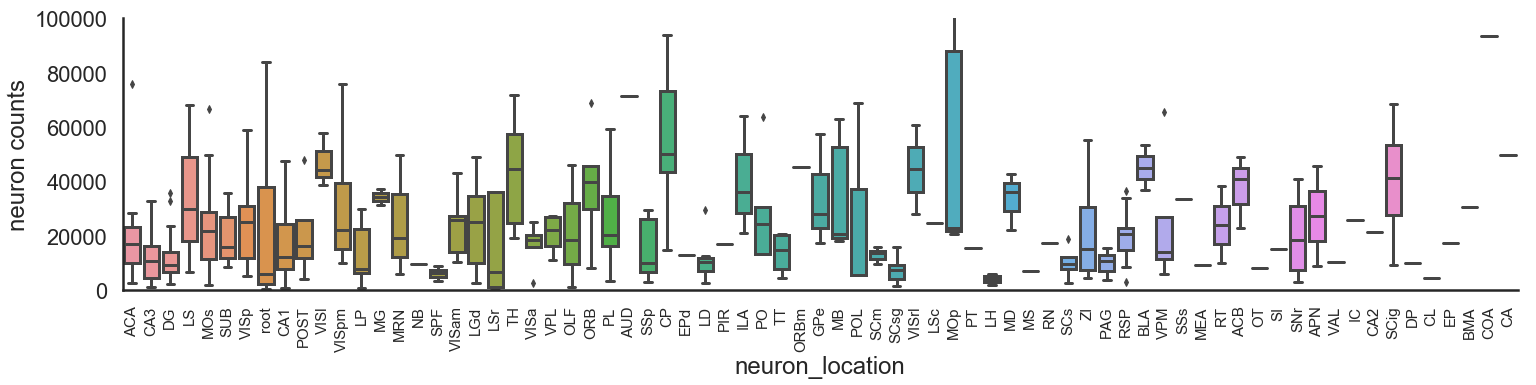

In [166]:
tmpdf = (
    spike_df
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','neuron_num','neuron_location',])
    .groupby(['session', 'mouse_name', 'neuron_location'])[0]
    .count()
    .rename('counts')
    .reset_index()
)

_, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x='neuron_location', y='counts', data=tmpdf,)
sns.despine()
ax.set_ylim(0,100000)
ax.set_ylabel('neuron counts')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
print(f'Number of recorded brain areas: {len(ax.get_xticklabels())}')

## LFP Data

In [6]:
#dataframe with spike info for each session, mouse and trial. Columns signify time bins of 10ms
lfp_df = pd.DataFrame() 
#loop through all sessions
for session, data in enumerate(alldat):
    #loop through trial_data from all neurons
    for lfp_num, lfp_data in enumerate(data['lfp']):
#         print(neuron_data.shape)
        tmpdf = pd.DataFrame(lfp_data, columns=list(range(lfp_data.shape[1])))
        tmpdf['trial_num'] = tmpdf.index.values
        tmpdf['response'] = data['response']
        tmpdf['response_time'] = data['response_time'].squeeze()
        tmpdf['go_cue'] = data['gocue'].squeeze()
        tmpdf['feedback_type'] = data['feedback_type'].squeeze()
        tmpdf['feedback_time'] = data['feedback_time']
        tmpdf['contrast_diff'] = data['contrast_right'] - data['contrast_left']
        tmpdf['lfp_num'] = lfp_num
        tmpdf['lfp_location'] = data['brain_area_lfp'][lfp_num]
        tmpdf['session'] = session
        tmpdf['mouse_name'] = data['mouse_name']
        lfp_df = pd.concat([lfp_df, tmpdf], ignore_index=True)

    
lfp_df.to_pickle(f'{data_path}/mouse_data_lfp.pkl')
lfp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,response,response_time,go_cue,feedback_type,feedback_time,contrast_diff,lfp_num,lfp_location,session,mouse_name
0,-2.850794,-4.039683,-4.195238,-3.228571,0.460317,6.749206,15.949206,3.438095,1.193651,18.515873,...,1.0,1.150204,1.027216,1.0,1.186819,-1.0,0,ACA,0,Cori
1,9.142630,11.475964,14.764853,11.609297,10.087075,6.287075,1.020408,-9.490703,-16.690703,-16.035147,...,-1.0,1.399503,0.874414,1.0,1.437623,0.5,0,ACA,0,Cori
2,2.656689,4.545578,7.656689,6.512245,-4.698866,-10.309977,-15.332200,-16.643311,-7.065533,8.534467,...,1.0,0.949291,0.825213,1.0,0.986016,-0.5,0,ACA,0,Cori
3,-9.866213,-12.632880,-8.232880,-15.021769,-7.699546,5.456009,0.122676,11.489342,19.267120,7.733787,...,0.0,2.266802,0.761612,1.0,2.296436,0.0,0,ACA,0,Cori
4,13.496145,22.851701,24.296145,27.840590,29.162812,23.062812,23.462812,23.007256,15.862812,5.762812,...,1.0,0.816776,0.662010,-1.0,0.827613,0.5,0,ACA,0,Cori


In [7]:
(lfp_df
#     .query('neuron_location == "VISa"')
    .set_index(
        ['session', 'mouse_name', 'trial_num', 'lfp_num', 'lfp_location',]
    )
).head()

0          1  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           -2.850794  -4.039683   
                   1         0       ACA            9.142630  11.475964   
                   2         0       ACA            2.656689   4.545578   
                   3         0       ACA           -9.866213 -12.632880   
                   4         0       ACA           13.496145  22.851701   

                                                           2          3  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           -4.195238  -3.228571   
                   1         0       ACA           14.764853  11.609297   
                   2         0       ACA            7.656689   6.512245   
                   3         0       ACA           -8.232880 -15.021769   
                   4         0       ACA           24.296145  27.840590   

                                                           4          5  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA            0.460317   6.749206   
                   1         0       ACA           10.087075   6.287075   
                   2         0       ACA           -4.698866 -10.309977   
                   3         0       ACA           -7.699546   5.456009   
                   4         0       ACA           29.162812  23.062812   

                                                           6          7  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           15.949206   3.438095   
                   1         0       ACA            1.020408  -9.490703   
                   2         0       ACA          -15.332200 -16.643311   
                   3         0       ACA            0.122676  11.489342   
                   4         0       ACA           23.462812  23.007256   

                                                           8          9  ...  \
session mouse_name trial_num lfp_num lfp_location                        ...   
0       Cori       0         0       ACA            1.193651  18.515873  ...   
                   1         0       ACA          -16.690703 -16.035147  ...   
                   2         0       ACA           -7.065533   8.534467  ...   
                   3         0       ACA           19.267120   7.733787  ...   
                   4         0       ACA           15.862812   5.762812  ...   

                                                         246        247  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA            1.593651   0.726984   
                   1         0       ACA           15.053741   3.031519   
                   2         0       ACA          -15.098866 -17.987755   
                   3         0       ACA           -4.243991  -6.155102   
                   4         0       ACA           -3.526077   5.407256   

                                                         248        249  \
session mouse_name trial_num lfp_num lfp_location                         
0       Cori       0         0       ACA           -2.217460  10.993651   
                   1         0       ACA            9.209297   7.975964   
                   2         0       ACA          -17.654422 -11.543311   
                   3         0       ACA           -4.299546 -16.866213   
                   4         0       ACA            5.540590  -0.514966   

                                                   response  response_time  \
session mouse_name trial_num lfp_num lfp_location                            
0       Cori       0         0       ACA                1.0       1.150204   
                   1         0       ACA               -1.0       1.399503   
                   2         0

Number of LFP areas: 72


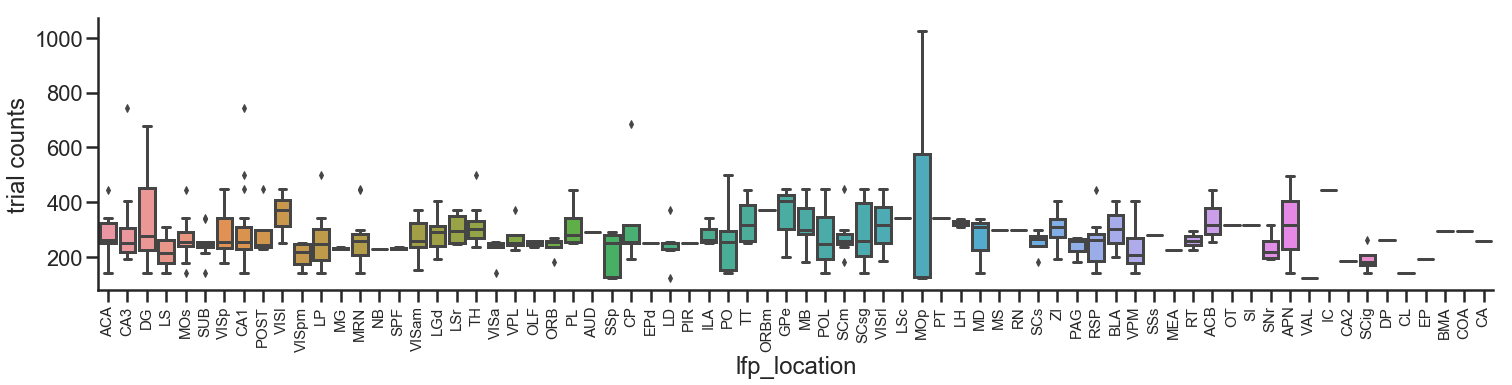

In [8]:
index_cols = ['session', 'mouse_name', 'trial_num', 'lfp_num', 'lfp_location',]
tmpdf = (
    lfp_df
#     .query('neuron_location == "VISa"')
    .set_index(index_cols)
    .groupby(['session', 'mouse_name', 'lfp_location'])[0]
    .count()
    .rename('trial_counts')
    .reset_index()
)

_, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x='lfp_location', y='trial_counts', data=tmpdf,)
sns.despine()
ax.set_ylabel('trial counts')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
print(f'Number of LFP areas: {len(ax.get_xticklabels())}')

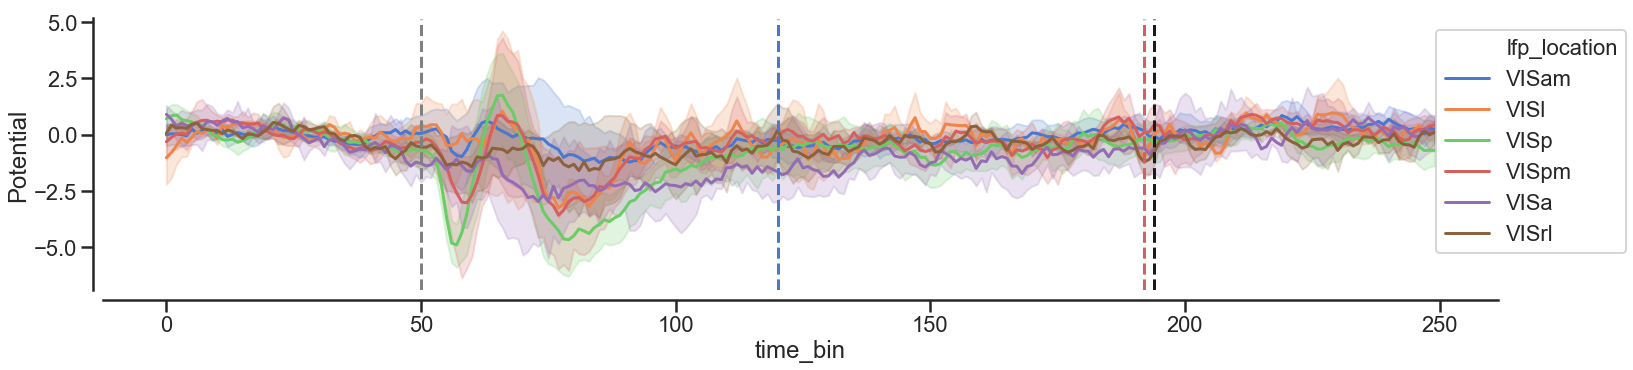

In [412]:
tmpdf = (
    lfp_df
    .drop(columns = ['go_cue', 'response', 'response_time', 'feedback_type', 'feedback_time', 'contrast_diff'])
#     .query('neuron_location == "VISa"')
    .set_index(['session', 'mouse_name','trial_num','lfp_num','lfp_location'])
    .groupby(['mouse_name', 'lfp_location'])
    .mean()
#     .rename('trial_counts')
#     .reset_index()
)
tmpdf = pd.melt(
    (tmpdf
     .reset_index()
     .query('lfp_location.str.startswith("VIS")')
#      .query('lfp_location == "ZI"')
    ), 
    id_vars=['lfp_location'], 
    value_vars = [col for col in tmpdf.columns if col != 'lfp_location'],
    var_name='time_bin',
    value_name = 'potential'
)
# display(tmpdf.head())
_, ax = plt.subplots(figsize=(25,5))
ax = sns.lineplot(x='time_bin', y='potential', hue='lfp_location', data=tmpdf, ax=ax)
sns.despine(offset=10)
ax.axvline(50, ls='--', color='grey') # stim_onset
ax.axvline(
    50 # stim_onset index
    + (
    behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .go_cue
    .mean()//0.01),
    ls='--', 
    color='b'
)
ax.axvline(
    50 
    + (
    behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .response_time
    .mean()//0.01),
    ls='--', 
    color='r'
)
ax.axvline( 
    50 
    + (behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .feedback_time
    .mean()//0.01),
    ls='--', 
    color='k'
)
ax.set_ylabel('Potential')
ax.legend(bbox_to_anchor=[1.1, 1])
# print(behavior_df.go_cue.median()//0.01, behavior_df.response_time.median()//0.01)
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=15);
# print(f'Number of LFP areas: {len(ax.get_xticklabels())}')

In [60]:
behavior_df.mouse_name.unique() # so cute

array(['Cori', 'Forssmann', 'Hench', 'Lederberg', 'Moniz', 'Muller',
       'Radnitz', 'Richards', 'Tatum', 'Theiler'], dtype=object)

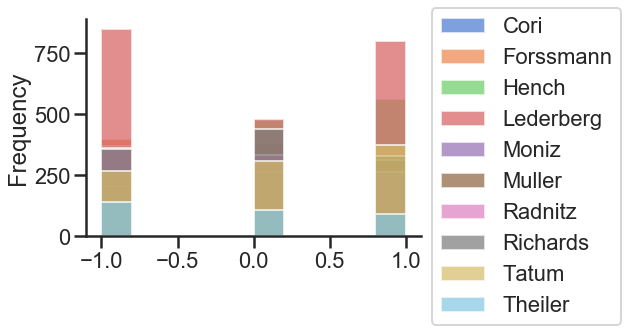

In [13]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .response
    .plot(kind='hist', legend=True, stacked=False, ax=ax, alpha=0.7)
);
ax.legend(bbox_to_anchor=[1., 1.1])
sns.despine()

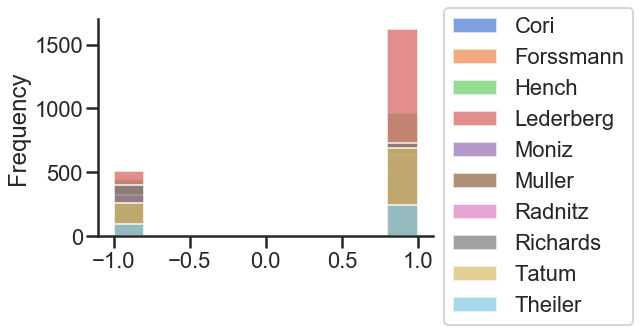

In [14]:
_, ax = plt.subplots()
(
    behavior_df
    .groupby(['mouse_name'])
    .feedback_type
    .plot(kind = 'hist', legend=True, stacked=True, ax=ax, alpha=0.7)
);
ax.legend(bbox_to_anchor=[1., 1.1])
sns.despine()

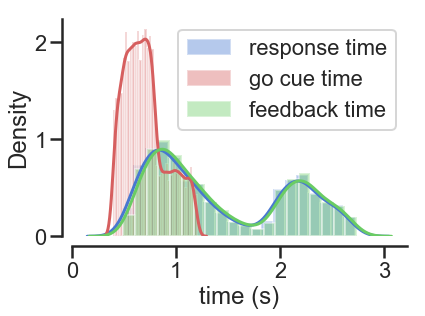

In [15]:
ax = sns.distplot(
    behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .response_time,
    color='b',
    label='response time'
)
ax = sns.distplot(
    behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .go_cue,
    color='r',
    label='go cue time'
)
ax = sns.distplot(
    behavior_df
#     .query('response_time > go_cue and response_time <= 1.5')
    .feedback_time,
    color='g',
    label='feedback time'
)
ax.set_ylabel('Density')
ax.set_xlabel('time (s)')
ax.legend(bbox_to_anchor=[1, 1])
sns.despine(offset=10)
#comparison of trialtypes, correct/incorrect, different contrasts 

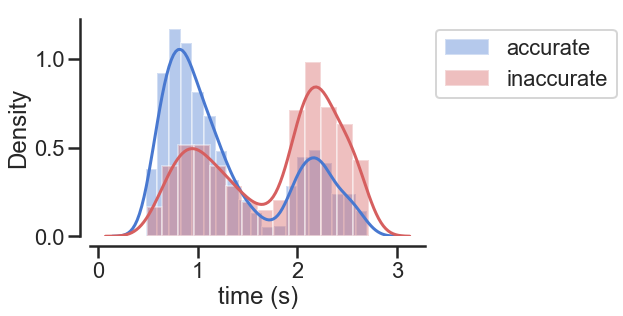

In [16]:
ax = sns.distplot(
    behavior_df
    .query('response_time > go_cue and isAccurate == 1')
    .response_time,
    color='b',
    label='accurate'
)
ax = sns.distplot(
    behavior_df
    .query('response_time > go_cue and isAccurate == 0')
    .response_time,
    color='r',
    label='inaccurate'
)
ax.set_ylabel('Density')
ax.set_xlabel('time (s)')
ax.legend(bbox_to_anchor=[1, 1])
sns.despine(offset=10)

In [17]:
display(behavior_df.response_time.describe())
display(behavior_df.go_cue.describe())

count    10050.000000
mean         1.422832
std          0.661416
min          0.479414
25%          0.842289
50%          1.183334
75%          2.102538
max          2.713576
Name: response_time, dtype: float64

count    10050.000000
mean         0.705904
std          0.200472
min          0.395066
25%          0.550406
50%          0.676430
75%          0.804812
max          1.198819
Name: go_cue, dtype: float64

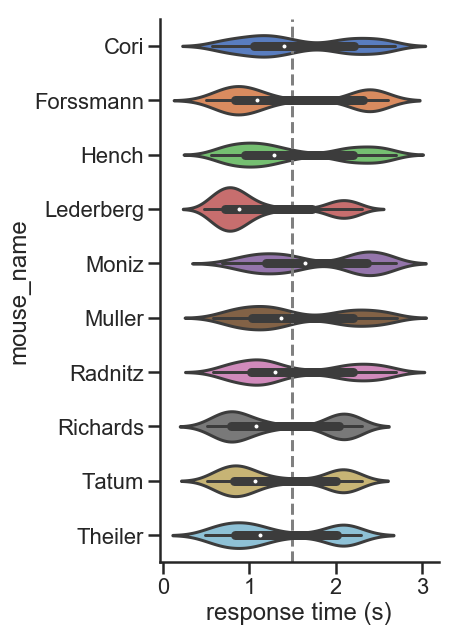

In [18]:
_, ax = plt.subplots(figsize=(5,10))
ax.axvline(1.5, ls='--', color='grey')
ax = sns.violinplot(y='mouse_name', x='response_time', data=behavior_df,)
sns.despine()
ax.set_xlabel('response time (s)');
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0);
## remove trials with response time over 1.5s??

In [411]:
# display(behavior_df.query('response_time <= 1.5').groupby('session').trial_num.count())
# display(behavior_df.query('response_time > 1.5').trial_num.count())
display(
    behavior_df
    .query('response_time > go_cue and response_time <= 1.5')
#     .groupby('session')
    .trial_num
    .count()
)
display(
    behavior_df
    .query('response_time < go_cue and response_time > 1.5')
    [['session', 'trial_num']]
#     .groupby('session')
#     .trial_num
#     .count()
)

6129

,session,trial_num


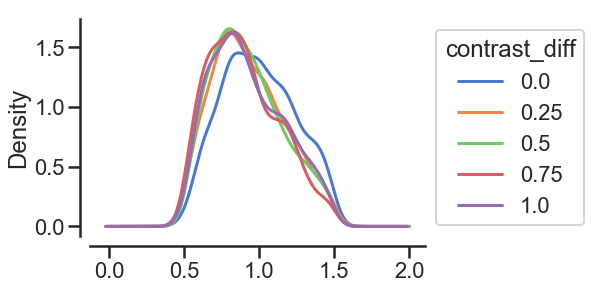

In [20]:
_, ax = plt.subplots()
(
    behavior_df
    .query('response_time > go_cue and response_time <= 1.5')
    .groupby('contrast_diff')
    .response_time
    .plot(kind='kde', ax=ax)
)
ax.legend(title='contrast_diff', bbox_to_anchor=[1, 1])
sns.despine(offset=10)

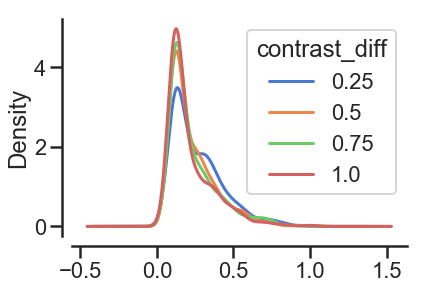

In [21]:
_, ax = plt.subplots()
behavior_df['res_gocue'] = (
    behavior_df.response_time - behavior_df.go_cue
)
(
    behavior_df
    .query('response_time > go_cue') 
    .query('response_time <= 1.5')
    .query('contrast_diff != 0.0')
    .groupby('contrast_diff')
    .res_gocue
    .plot(kind='kde', ax=ax)
)
ax.legend(title='contrast_diff', bbox_to_anchor=[1, 1])
sns.despine(offset=10)

In [22]:
id_cols = ['session', 'mouse_name', 'trial_num', 'response', 'response_time', 'go_cue', 
           'feedback_type', 'feedback_time', 'contrast_diff', 'lfp_num', 'lfp_location',]
(
    lfp_df
    .melt(
        id_vars=id_cols, 
        value_vars = [col for col in lfp_df.columns if col not in id_cols],
        var_name='time_bin',
        value_name = 'potential'
         )
    .set_index(['session', 'mouse_name', 'trial_num'])
)

response  response_time    go_cue  \
session mouse_name trial_num                                      
0       Cori       0               1.0       1.150204  1.027216   
                   1              -1.0       1.399503  0.874414   
                   2               1.0       0.949291  0.825213   
                   3               0.0       2.266802  0.761612   
                   4               1.0       0.816776  0.662010   
...                                ...            ...       ...   
38      Theiler    338             0.0       2.297503  0.794097   
                   339            -1.0       1.158803  0.524700   
                   340             0.0       2.003709  0.504257   
                   341             0.0       2.076758  0.574262   
                   342             0.0       2.101029  0.589720   

                              feedback_type  feedback_time  contrast_diff  \
session mouse_name trial_num                                                
0       Cori       0                    1.0       1.186819          -1.00   
                   1                    1.0       1.437623           0.50   
                   2                    1.0       0.986016          -0.50   
                   3                    1.0       2.296436           0.00   
                   4                   -1.0       0.827613           0.50   
...                                     ...            ...            ...   
38      Theiler    338                 -1.0       2.297503          -0.75   
                   339                 -1.0       1.158803          -0.75   
                   340                 -1.0       2.003709          -0.75   
                   341                 -1.0       2.076758          -0.75   
                   342                 -1.0       2.101029          -0.75   

                              lfp_num lfp_location time_bin  potential  
session mouse_name trial_num                                            
0       Cori       0                0          ACA        0  -2.850794  
                   1                0          ACA        0   9.142630  
                   2                0          ACA        0   2.656689  
                   3                0          ACA        0  -9.866213  
                   4                0          ACA        0  13.496145  
...                               ...          ...      ...        ...  
38      Theiler    338              9           PL      249   2.634439  
                   339              9           PL      249   8.869898  
                   340              9           PL      249   1.733418  
                   341              9           PL      249 -18.153571  
                   342              9           PL      249  33.601786  

[22640250 rows x 10 columns]

## Predict accuracy of choice based on PC of LFP and choice history

In [308]:
# Helper functions

def get_Xy(lfp_df, session, period='post_stimulus'):
    id_cols = ['session', 'mouse_name', 'trial_num', 'response', 'response_time', 'go_cue', 
           'feedback_type', 'feedback_time', 'contrast_diff', 'lfp_num', 'lfp_location',]
    
    #choose only trials where contrast_diff > 0
    trial_num = behavior_df.query("session == @session and contrast_diff > 0").trial_num
#     print(trial_num)
    
    tmpdf = lfp_df.query('session == @session and trial_num in @trial_num')
    
    if period == 'pre_stimulus':
        offset_stop = 50 
        offset_start = 0 
    elif period == 'post_stimulus':
        offset_stop = 50 + (tmpdf.response_time.min())//0.01
        offset_start = 50 
    else:
        offset_stop = 50 + (tmpdf.go_cue.min())//0.01
        offset_start = 50 
    
    select_cols = [col for col in tmpdf.columns 
                   if col not in id_cols and col >= offset_start and col <= offset_stop]
    # print(select_cols, offset_start, offset_stop)
    select_cols.extend(['trial_num', 'lfp_location', ])
    
    tmpdf = tmpdf[select_cols]
    # print(select_cols[:-2])
    tmpdf.drop_duplicates(['trial_num', 'lfp_location'], keep='first', inplace=True)
    
    tmpdf = pd.pivot(data=tmpdf, index='trial_num', columns='lfp_location')    
    tmpdf = tmpdf.swaplevel(0,1, axis=1).sort_index(axis=1)
    
    tmpdf.columns = [col + '_' + str(i) for col, i in tmpdf.columns.values]
    
    X = tmpdf.to_numpy()
#     y = behavior_df.query("session == @session and trial_num in @trial_num").sort_values(by='trial_num').response.replace({1:1, -1: 0})
    y = behavior_df.query("session == @session and trial_num in @trial_num").sort_values(by='trial_num').isAccurate

    #rewards = behavior_df.query("session == @session and trial_num in @trial_num").sort_values(by='trial_num').feedback_type
    feature_names = tmpdf.columns.to_list()
#     if add_choice_history:
#         X_augmented = X        
        
#         for choice_num in range(1, choice_history_num + 1):
#             X_augmented = np.column_stack((X_augmented, np.zeros_like(y)))
#             X_augmented[choice_num:,-1] = y[:-choice_num]
#             X_augmented[choice_num:,-1] = rewards[:-choice_num]
            
#         X = X_augmented[choice_history_num:, :]
#         y = y[choice_history_num:]
#         feature_names.extend(['choice_hist_' + (str(choice)) for choice in range(choice_history_num)])
#     print(X.shape, y.shape)
    return X, y, feature_names

def get_PCA(X, n_components):
    X_demean = (X - X.mean(axis=0))/X.std(axis=0)
#     print(X.shape)
    X_pca = PCA(n_components=n_components,).fit_transform(X)
    return X_pca

def add_behavior(X, y, choice_history_num=1):
    X_augmented = X 
        
    for choice_num in range(1, choice_history_num + 1):
        X_augmented = np.column_stack((X_augmented, np.zeros_like(y)))
        X_augmented[choice_num:,-1] = y[:-choice_num]
#         X_augmented[choice_num:,-1] = rewards[:-choice_num]

    X = X_augmented[choice_history_num:, :]
    y = y[choice_history_num:]
    return X, y

In [357]:
n_components = 100
choice_history_num = 3
models_df = pd.DataFrame(columns=['session', 'X_pca', 'selected_idx',
                                  'selected_features', 'best_C',
                                  'train_accuracy', 'mean_accuracy_cv', 'test_accuracy',
                                  'mean_mouse_accuracy'
                                 ]
)

for session in lfp_df.session.unique():
    try:
        print(session)
        # make design matrix
        X, y, _ = get_Xy(lfp_df, session, period='pre_stimulus')
        
        # convert data to ndarray
        X, y = np.asarray(X), np.asarray(y)
        
        # compute PCA
        X_pca = get_PCA(X, n_components)
        
        #add choice history to design matrix
        X, y = add_behavior(X_pca, y, choice_history_num=choice_history_num) 
        
#         X = X[:,-choice_history_num:]
        
        # split data from cross-validation
        kf = KFold(n_splits=5)        
        
        # initialize lists to store cross-val data
        train_accuracy_list = []
        test_accuracy_list = []
        selected_features = []
        selected_features_idx = []
        best_params = {'C' : [], 'gamma': []}
        
        #loop through folds
        for train_index, test_index in kf.split(X):
#           #get train-test splits
            X_train, X_test = X[train_index, :], X[test_index, :]
            y_train, y_test = y[train_index], y[test_index] 
        
            # which estimator?
#             feature_estimator = LogisticRegression(C=1, penalty="l1", solver="saga", max_iter=100000)
            estimator = LinearSVC(penalty='l1', dual=False, tol=1e-3)
#             estimator = SVC(max_iter = 100000, tol = 1e-3),
            
            # feature selection
            selector = SelectFromModel(estimator=estimator.fit(X_train, y_train), prefit=True)
#             print(f'Number of features selected: {selector.get_support().sum()}')
            selected_features_idx.append(selector.get_support())
            X_reduced = selector.transform(X_train)
            
#             # tune params for best accuracy
            tuned_parameters = [{'kernel': ['linear'], 
                                 'C': 10**np.arange(-4,1,1).astype(float),
                                 'gamma': 10**np.arange(-4,4,1).astype(float),}]

            gridcv = GridSearchCV(
                estimator=SVC(max_iter = 100000, tol = 1e-3),
                param_grid=tuned_parameters,
                scoring='precision',
                cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=3),
            )
                   
            clf = gridcv.fit(X_reduced, y_train)
            
            #fit log reg on selected features
#             log_reg = LogisticRegression(
#                 penalty='l1', 
#                 C=1, 
#                 solver="saga", 
#                 max_iter=100000
#             ).fit(selector.transform(X_train),y_train)
            
            # get predictions
#             y_pred = log_reg.predict(selector.transform(X_test))

            # get train scores and append to list
            score = clf.score(X_reduced, y_train)        
            train_accuracy_list.append(score)
            
            # get test scores and append to list
            score = clf.score(selector.transform(X_test), y_test)        
#             score = clf.score(X_test, y_test)   
            test_accuracy_list.append(score)
            
            # find number of features selected and append to list
            coef_num = selector.get_support().sum()
            selected_features.append(coef_num)
            
            best_params['C'].append(gridcv.best_params_['C'])
            best_params['gamma'].append(gridcv.best_params_['gamma'])
        
        # fill out model summaries
        models_df.loc[session, 'session'] = session
        models_df.loc[session, 'X_pca'] = X_pca
        models_df.loc[session, 'mean_accuracy_cv'] = np.mean(test_accuracy_list)
        models_df.loc[session, 'test_accuracy'] = test_accuracy_list
        models_df.loc[session, 'train_accuracy'] = train_accuracy_list
        models_df.loc[session, 'mean_mouse_accuracy'] = y.mean()
        models_df.loc[session, 'selected_features'] = selected_features
        models_df.loc[session, 'best_C'] = best_params['C']
        models_df.loc[session, 'selected_idx'] = selected_features_idx

    except ValueError:
        print(f'Error in session: {session}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Error in session: 20
21
22
23
24
25
26
27
28
Error in session: 28
29
30
31
32
33
34
35
36
37
38


In [358]:
# models_df.to_pickle(f'{data_path}/post_stim_predictions.pkl')
models_df.to_pickle(f'{data_path}/pre_stim_predictions.pkl')

In [359]:
models_df.sort_values(by='mean_accuracy_cv', ascending=False).head()

,session,X_pca,selected_idx,selected_features,best_C,train_accuracy,mean_accuracy_cv,test_accuracy,mean_mouse_accuracy
12,12,"[[-100.47859395017583, -195.92963585362543, -3...","[[True, True, True, True, True, True, True, Tr...","[87, 86, 97, 88, 81]","[0.001, 0.0001, 0.001, 0.001, 0.001]","[1.0, 0.9657534246575342, 1.0, 1.0, 1.0]",0.896676,"[0.9705882352941176, 0.9642857142857143, 0.967...",0.9
11,11,"[[-125.21052365966712, -31.57271558571906, -20...","[[True, True, True, True, True, True, True, Tr...","[87, 84, 96, 91, 88]","[0.001, 0.001, 0.001, 0.0001, 0.0001]","[1.0, 1.0, 1.0, 0.9662162162162162, 0.99358974...",0.87157,"[0.9117647058823529, 0.96875, 0.85294117647058...",0.867299
17,17,"[[13.817488077843779, 136.12574601871123, 63.9...","[[True, True, True, True, False, True, False, ...","[85, 94, 79, 87, 82]","[0.001, 0.001, 0.001, 0.001, 0.0001]","[1.0, 1.0, 1.0, 1.0, 0.9871794871794872]",0.864976,"[0.9411764705882353, 0.9375, 0.947368421052631...",0.864078
16,16,"[[-93.25022230275667, 29.823547090092855, -0.2...","[[True, False, True, True, True, True, True, T...","[68, 70, 74, 76, 65]","[0.01, 0.001, 0.01, 0.01, 0.001]","[1.0, 1.0, 1.0, 1.0, 1.0]",0.861408,"[0.9642857142857143, 0.9166666666666666, 0.913...",0.871795
24,24,"[[13.610162138997232, 38.84475875941394, 69.44...","[[True, True, True, True, True, True, True, Tr...","[81, 78, 80, 82, 80]","[0.01, 0.01, 0.001, 0.0001, 0.001]","[1.0, 1.0, 1.0, 0.9245283018867925, 1.0]",0.839989,"[0.92, 0.9166666666666666, 0.88, 0.96153846153...",0.825806


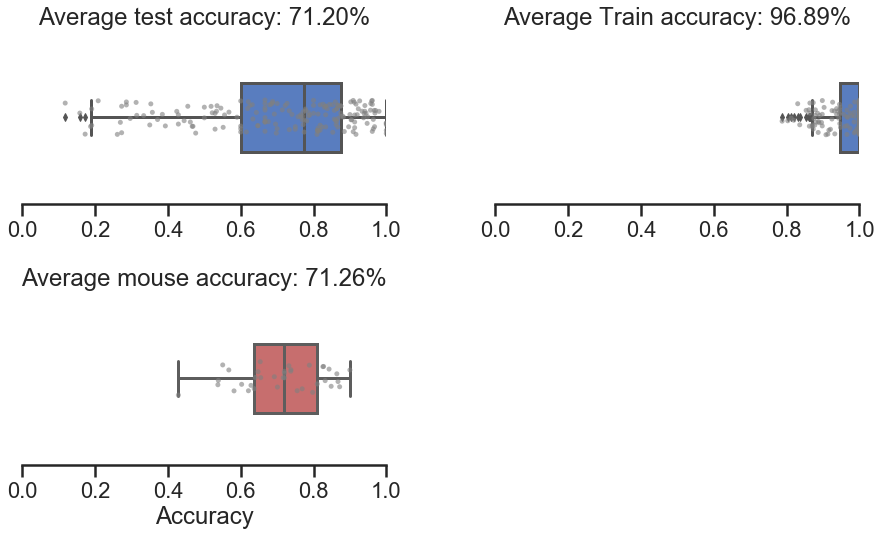

In [360]:
f, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=False)
ax = ax.ravel()
plt.subplots_adjust(hspace=.5, wspace=0.3)

l = models_df.test_accuracy.to_list()
test_flatten = [item for sublist in l for item in sublist]

sns.boxplot(x=test_flatten, ax=ax[0], width=0.4)
sns.stripplot(x=test_flatten, ax=ax[0], color='grey', alpha=0.6)
sns.despine(left=True)

l = models_df.train_accuracy.to_list()
train_flatten = [item for sublist in l for item in sublist]

sns.boxplot(x=train_flatten, ax=ax[1], width=0.4)
sns.stripplot(x=train_flatten, ax=ax[1], color='grey', alpha=0.6)
sns.despine(left=True)

models_df.mean_mouse_accuracy = models_df.mean_mouse_accuracy.astype(float)
sns.boxplot(data=models_df, x='mean_mouse_accuracy', color='r', ax=ax[2], width=0.4)
sns.stripplot(data=models_df, x='mean_mouse_accuracy', ax=ax[2], color='grey', alpha=0.6)
sns.despine(left=True)
# sns.despine(left=True)

ax[0].set(
#   xlabel="Accuracy",
  yticks=[],
  xlim=(0., 1),
  title=f"Average test accuracy: {np.mean(test_flatten):.2%}"
)
ax[1].set(
#   xlabel="Accuracy",
  yticks=[],
  xlim=(0., 1),
  title=f"Average Train accuracy: {np.mean(train_flatten):.2%}"
)
ax[2].set(
  xlabel="Accuracy",
  yticks=[],
  xlim=(0., 1),
  title=f"Average mouse accuracy: {models_df.mean_mouse_accuracy.mean():.2%}"
)
ax[3].axis('off');


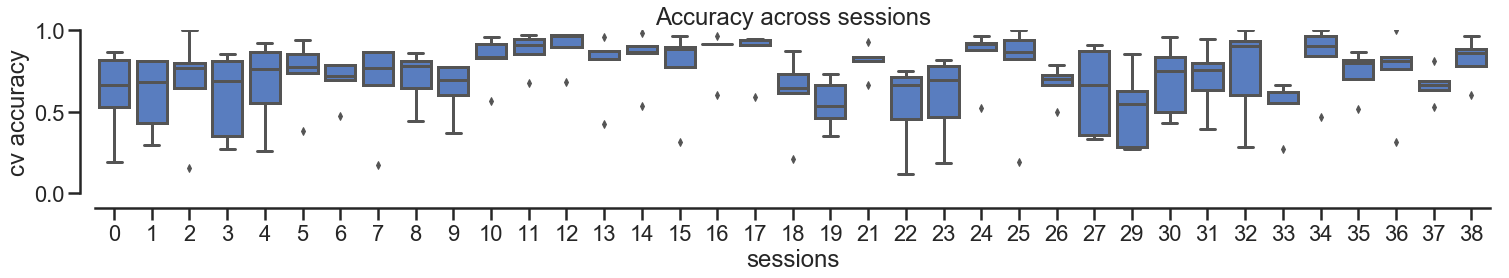

In [361]:
f, ax = plt.subplots(1, figsize=(25, 3), sharex=False)
lst_col = 'test_accuracy'
tmpdf = models_df[['session', 'test_accuracy']]
tmpdf = pd.DataFrame({
      col:np.repeat(tmpdf[col].values, tmpdf[lst_col].str.len())
      for col in tmpdf.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(tmpdf[lst_col].values)})[tmpdf.columns]

ax = sns.boxplot(data=tmpdf, y='test_accuracy',x='session', color='b', ax=ax)
sns.despine(offset=15)
ax.set(
  xlabel="sessions",
  ylabel='cv accuracy',
  ylim=(0, 1),
#   xlim=(0, 36),
  yticks=[0, 0.5, 1],
  xticks=range(0,39),
  title=f"Accuracy across sessions"
);
# display(tmpdf.session.values)

In [248]:
models_df = pd.read_pickle(f'{data_path}/predictions.pkl')

In [321]:
models_df['acc_diff'] = models_df.mean_accuracy_cv - models_df.mean_mouse_accuracy
models_df.sort_values(by='acc_diff', ascending=False).head(3)

,session,X_pca,selected_idx,selected_features,best_C,train_accuracy,mean_accuracy_cv,test_accuracy,mean_mouse_accuracy,acc_diff
0,0,"[[144.45353048007067, -54.35131548749356, -10....","[[True, True, True, True, True, True, True, Tr...","[97, 91, 88, 92, 95]","[0.0001, 0.001, 0.0001, 0.0001, 0.0001]","[0.9726027397260274, 1.0, 0.9871794871794872, ...",0.754363,"[0.9354838709677419, 0.782608695652174, 0.8888...",0.653595,0.100769
1,1,"[[7.679801990548995, 11.411193488771321, -1.39...","[[True, True, True, True, True, True, True, Tr...","[99, 97, 94, 96, 90]","[0.0001, 0.0001, 0.001, 0.0001, 0.01]","[0.9166666666666666, 0.9130434782608695, 0.988...",0.714766,"[0.8333333333333334, 0.875, 0.4210526315789473...",0.621118,0.0936481
29,29,"[[-245.94220374515345, -170.21585695762445, 34...","[[True, True, True, True, True, True, True, Tr...","[90, 90, 90, 83, 90]","[0.0001, 0.0001, 0.0001, 0.0001, 0.0001]","[1.0, 1.0, 1.0, 1.0, 1.0]",0.486905,"[0.8571428571428571, 0.5, 0.6666666666666666, ...",0.428571,0.0583333


In [370]:
session = 0
X_pca = models_df.query('session == 0').X_pca.to_numpy()
X, y, features_names = get_Xy(lfp_df, session, period='post_stimulus')
# print(X_pca[0].shape)
X_pca = X_pca[0]
y = y.to_numpy()

# print(X_pca[:, 1])

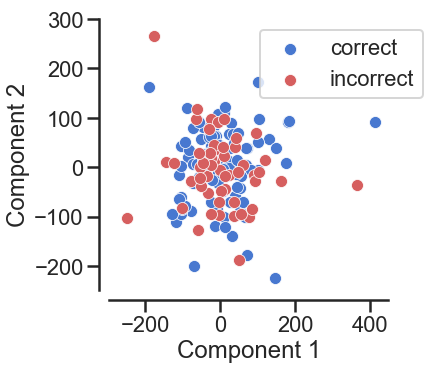

In [410]:
_, ax = plt.subplots(figsize=(5,5))

# print(X_pca[y==1, 1])
sns.scatterplot(x=X_pca[y==1, 1], y=X_pca[y==1, 2], color='b', label='correct')
sns.scatterplot(x=X_pca[y==0, 1], y=X_pca[y==0, 2], color='r', label='incorrect')
sns.despine(offset=10)
ax.set(
#     ylim = (-200, 400),
#     xlim = (-200, 400),
#     yticks = [-200, 0, 200, 400],
    xlabel = 'Component 1',
    ylabel = 'Component 2'
)
ax.legend(bbox_to_anchor=(0.5,1))

In [369]:
mu = np.mean(X, axis=0)
pca = PCA()
pca.fit(X)

nComp = 1
Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu
print(Xhat.shape)

(156, 413)


In [396]:
xx = np.reshape(Xhat, (156, 7, 59))

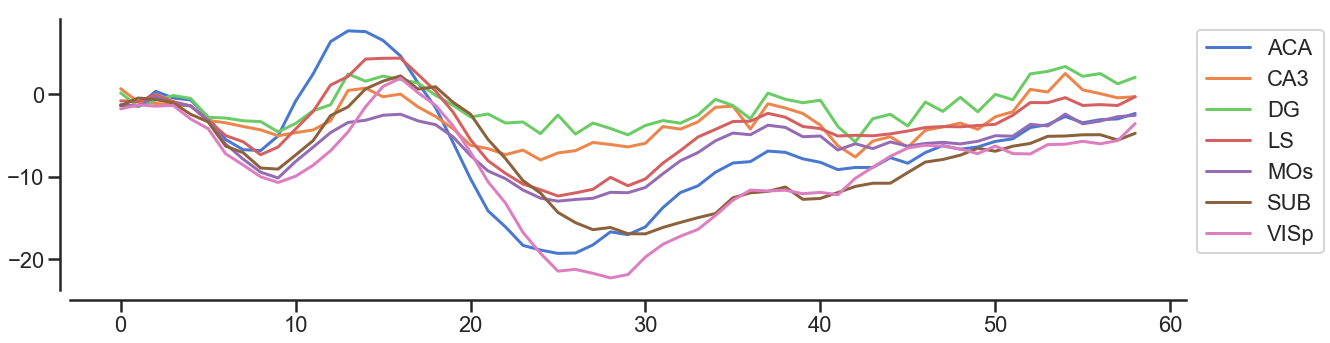

In [409]:
_, ax = plt.subplots(figsize=(20,5))

regions = np.unique([fn.split('_')[0] for fn in features_names ])

for i in range(xx.shape[1]):
    ax = sns.lineplot(y=xx[1, i, :], x=np.arange(0, 59), ax=ax, label=regions[i])
sns.despine(offset=10)

ax.legend(bbox_to_anchor=(1,1))